In [1]:
import pandas as pd
from urllib.request import Request, urlopen, urlretrieve
from pathlib import Path  
import ssl
import tqdm
import os
import re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import classification_report
%load_ext autoreload

/home/erniesg/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Start by defining some paths

In [2]:
BUCKET_NAME = 'art_api-sg'
#BUCKET_TRAIN_DATA_PATH = 'data/train_1k.csv'
BUCKET_TRAIN_DATA_PATH = 'yourpaintings'
PATH = Path("../raw_data")
PATH_YOURPAINTINGS = PATH/"yourpaintings"
MODEL_NAME = 'art_api'
MODEL_VERSION = 'baseline'

In [3]:
df_yourpaintings = pd.read_csv("https://www.robots.ox.ac.uk/~vgg/data/paintings/painting_dataset_2021.csv")
df_yourpaintings = df_yourpaintings.drop_duplicates()
df_yourpaintings = df_yourpaintings.dropna()
#df_yourpaintings = df_yourpaintings[15:20]
df_yourpaintings

,Image URL,Web page URL,Subset,Labels
0,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/and-the-co...,'test',' cow'
1,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/0-6-00-6-0...,'train',' train'
2,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/044t-locom...,'train',' train'
3,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/080-locomo...,'test',' train'
4,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/17th-and-2...,'test',' horse'
...,...,...,...,...
8623,https://d3d00swyhr67nd.cloudfront.net/w944h944...,https://artuk.org/discover/artworks/youth-82434,'test',' diningtable'
8625,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/yport-20094,'test',' boat'
8626,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/yport-norm...,'train',' bird'
8627,https://d3d00swyhr67nd.cloudfront.net/w944h944...,https://artuk.org/discover/artworks/zebra-and-...,'train',' bird'


In [39]:
test = pd.DataFrame([{'Image URL': 'http:// google.com',
                      'Web page URL': 'http://test.com',
                      'Subset': 'subset values',
                      'Labels': 'chair diningtable dog'}])

df_yourpaintings = pd.concat([df_yourpaintings, test], axis=0, ignore_index=True)
df_yourpaintings

,Image URL,Web page URL,Subset,Labels
0,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/a-seventee...,'test',' chair diningtable dog'
1,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/a-20-havoc...,'test',' aeroplane'
2,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/a-basket-o...,'train',' bird dog'
3,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/a-basket-o...,'train',' bird'
4,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/a-bather-7936,'test',' chair'
5,http:// google.com,http://test.com,subset values,chair diningtable dog


In [82]:
# for every row, save images from working urls and drop rows with inaccessible images
for index, row in df_yourpaintings.iterrows():
    url = str(row["Image URL"])
    fname = url[url.rfind("/")+1:]
    try:
        save_file = os.path.join(PATH_YOURPAINTINGS, fname)
        urlretrieve(url, save_file)
        df_yourpaintings.at[index, "filename"] = fname
    except:
        df_yourpaintings.drop(index=index, axis=0, inplace=True)

In [102]:
df_yourpaintings = df_yourpaintings.reset_index()

In [103]:
# extract labels into a new column called 'label_classes'
labels = []

for index, row in df_yourpaintings.iterrows():
    text = row["Labels"]
    labels.append(re.findall("[a-z]+", text, flags=re.IGNORECASE))

In [104]:
labels = pd.Series(labels)
df_yourpaintings["labels"] = labels

In [115]:
mlb = MultiLabelBinarizer()
df_yourpaintings = pd.concat([df_yourpaintings, pd.DataFrame(mlb.fit_transform(df_yourpaintings["labels"]), columns=mlb.classes_,)], axis=1)

In [5]:
#save images that are successfuly downloaded into a clean csv
PATH_FILE = Path(PATH_YOURPAINTINGS/"df_yourpaintings.csv")  
PATH_FILE.parent.mkdir(parents=True, exist_ok=True)
#df_yourpaintings.to_csv(PATH_FILE, index=False)

In [6]:
df = pd.read_csv(PATH_FILE)
df

,index,Image URL,Web page URL,Subset,Labels,filename,labels,aeroplane,bird,boat,chair,cow,diningtable,dog,horse,sheep,train
0,0,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/and-the-co...,'test',' cow',NID_QUB_QUB_264-001.jpg,['cow'],0,0,0,0,1,0,0,0,0,0
1,1,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/0-6-00-6-0...,'train',' train',GMIII_MOSI_A1978_72_3-001.jpg,['train'],0,0,0,0,0,0,0,0,0,1
2,2,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/044t-locom...,'train',' train',NY_NRM_1979_7964-001.jpg,['train'],0,0,0,0,0,0,0,0,0,1
3,3,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/080-locomo...,'test',' train',CHE_CRHC_PCF40-001.jpg,['train'],0,0,0,0,0,0,0,0,0,1
4,4,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/17th-and-2...,'test',' horse',NOT_NTMAG_1997_31-001.jpg,['horse'],0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8291,8623,https://d3d00swyhr67nd.cloudfront.net/w944h944...,https://artuk.org/discover/artworks/youth-82434,'test',' diningtable',LLR_AWC_0047-001.jpg,['diningtable'],0,0,0,0,0,1,0,0,0,0
8292,8625,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/yport-20094,'test',' boat',STF_STKMG_1965_FA_10-001.jpg,['boat'],0,0,1,0,0,0,0,0,0,0
8293,8626,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/yport-norm...,'train',' bird',NY_YAG_YORAG_1030-001.jpg,['bird'],0,1,0,0,0,0,0,0,0,0
8294,8627,https://d3d00swyhr67nd.cloudfront.net/w944h944...,https://artuk.org/discover/artworks/zebra-and-...,'train',' bird',GL_GM_A_1989_23_e-001.jpg,['bird'],0,1,0,0,0,0,0,0,0,0


In [12]:
df.columns

Index(['index', 'Image URL', 'Web page URL', 'Subset', 'Labels', 'filename',
       'labels', 'aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable',
       'dog', 'horse', 'sheep', 'train'],
      dtype='object')

# Build preprocessing pipeline to process images and encode in parallel

In [138]:
# do train_test_split before preprocessing
# resize, crop, augment
# optional: gray scale
# all these to be done before image is loaded as feature

In [13]:
imgs = []

In [23]:
for index, row in df.iterrows():
    img_file = str(row["filename"])
    image = Image.open(os.path.join(PATH_YOURPAINTINGS, img_file))
    image = image.resize((256, 256))
    imgs.append(np.array(image))

In [26]:
X = np.array(imgs)
X.shape

(8296, 256, 256, 3)

In [27]:
y = df.drop(columns=['index', 'Image URL', 'Web page URL', 'Subset', 'Labels', 'filename',
       'labels'])
y.shape

(8296, 10)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3)

In [31]:
def load_baseline_model():

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(256,256,3)))

    model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [32]:
model = load_baseline_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 247, 247, 16)      4816      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 82, 82, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        32800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        3

2022-09-04 15:45:03.794038: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-09-04 15:45:03.852349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-09-04 15:45:03.852365: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-09-04 15:45:03.853093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [33]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

In [36]:
history = model.fit(X_train, y_train,
                    validation_data=[X_val, y_val],
                    batch_size = 32, 
                    epochs = 10, 
                    callbacks=[es],
                    verbose=1)

Epoch 1/10
182/182 [==============================] - 187s 1s/step - loss: 0.3395 - accuracy: 0.2736 - val_loss: 0.3203 - val_accuracy: 0.3199
Epoch 2/10
182/182 [==============================] - 183s 1s/step - loss: 0.3139 - accuracy: 0.3237 - val_loss: 0.3088 - val_accuracy: 0.3440
Epoch 3/10
182/182 [==============================] - 186s 1s/step - loss: 0.3048 - accuracy: 0.3386 - val_loss: 0.3072 - val_accuracy: 0.3614
Epoch 4/10
182/182 [==============================] - 192s 1s/step - loss: 0.3000 - accuracy: 0.3585 - val_loss: 0.3006 - val_accuracy: 0.3628
Epoch 5/10
182/182 [==============================] - 183s 1s/step - loss: 0.2952 - accuracy: 0.3659 - val_loss: 0.2990 - val_accuracy: 0.3507
Epoch 6/10
182/182 [==============================] - 184s 1s/step - loss: 0.2919 - accuracy: 0.3776 - val_loss: 0.2996 - val_accuracy: 0.3588
Epoch 7/10
182/182 [==============================] - 232s 1s/step - loss: 0.2888 - accuracy: 0.3806 - val_loss: 0.2965 - val_accuracy: 0.3708

In [37]:
res = model.evaluate(X_test, y_test)
res

55/55 [==============================] - 8s 137ms/step - loss: 0.2904 - accuracy: 0.3760


[0.2903561592102051, 0.3760046064853668]

In [38]:
test_accuracy = res[-1]
print(f"test_accuracy = {round(test_accuracy,2)*100} %")

test_accuracy = 38.0 %


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


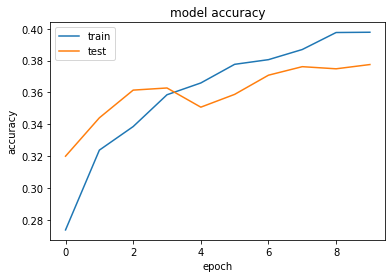

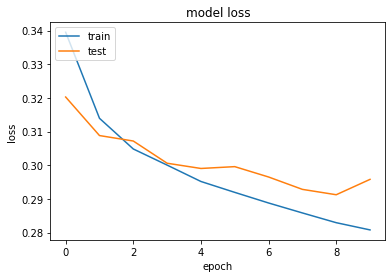

In [44]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
model.save(PATH_YOURPAINTINGS)

INFO:tensorflow:Assets written to: ../raw_data/yourpaintings/assets


INFO:tensorflow:Assets written to: ../raw_data/yourpaintings/assets


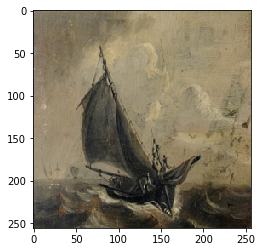

{'aeroplane': 0.011510649, 'bird': 0.058980286, 'boat': 0.4657647, 'chair': 0.107780285, 'cow': 0.05964142, 'diningtable': 0.13066083, 'dog': 0.07446681, 'horse': 0.0835417, 'sheep': 0.027961489, 'train': 0.0679767}


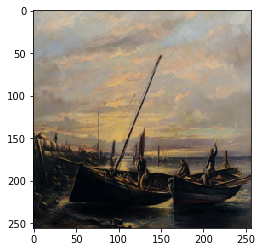

{'aeroplane': 0.0069908835, 'bird': 0.073846504, 'boat': 0.7109203, 'chair': 0.052852217, 'cow': 0.06628267, 'diningtable': 0.027389439, 'dog': 0.068699524, 'horse': 0.06838873, 'sheep': 0.055856816, 'train': 0.021909487}


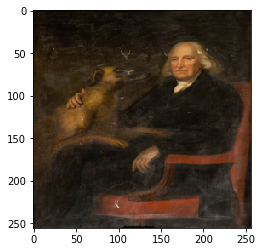

{'aeroplane': 0.0029774709, 'bird': 0.13786562, 'boat': 0.0416988, 'chair': 0.732465, 'cow': 0.020253956, 'diningtable': 0.43880045, 'dog': 0.15119307, 'horse': 0.086714655, 'sheep': 0.028905299, 'train': 0.010970064}


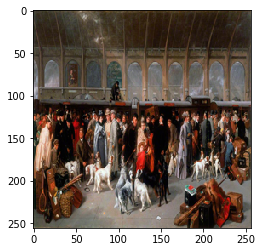

{'aeroplane': 0.00047224207, 'bird': 0.19782655, 'boat': 0.05197912, 'chair': 0.25675035, 'cow': 0.0047155037, 'diningtable': 0.38016063, 'dog': 0.21556155, 'horse': 0.040112652, 'sheep': 0.0067676483, 'train': 0.18043947}


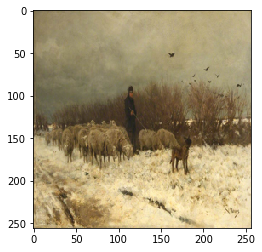

{'aeroplane': 0.013747182, 'bird': 0.08043737, 'boat': 0.33191603, 'chair': 0.029723644, 'cow': 0.09929886, 'diningtable': 0.057096746, 'dog': 0.16526976, 'horse': 0.1510413, 'sheep': 0.06962299, 'train': 0.01585079}


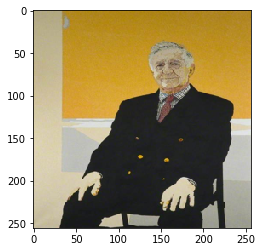

{'aeroplane': 0.00696808, 'bird': 0.030701378, 'boat': 0.25352976, 'chair': 0.22637038, 'cow': 0.002274111, 'diningtable': 0.2212968, 'dog': 0.066337705, 'horse': 0.029711854, 'sheep': 0.007477059, 'train': 0.016330788}


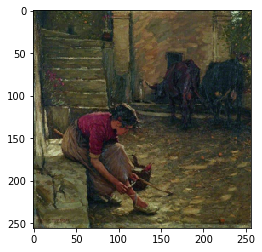

{'aeroplane': 0.014491059, 'bird': 0.25544348, 'boat': 0.11032209, 'chair': 0.24605648, 'cow': 0.075736314, 'diningtable': 0.29747686, 'dog': 0.23127078, 'horse': 0.1251727, 'sheep': 0.07669094, 'train': 0.120897636}


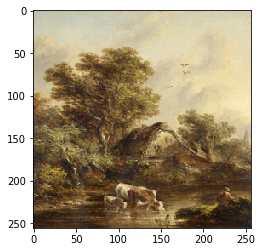

{'aeroplane': 0.0015015261, 'bird': 0.017672215, 'boat': 0.22402391, 'chair': 0.031162668, 'cow': 0.13949892, 'diningtable': 0.021721153, 'dog': 0.12647809, 'horse': 0.30596307, 'sheep': 0.11625271, 'train': 0.016982079}


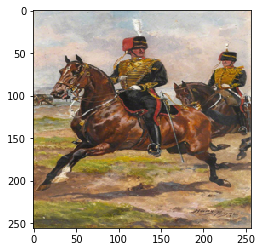

{'aeroplane': 0.002885907, 'bird': 0.06951065, 'boat': 0.05603365, 'chair': 0.046981283, 'cow': 0.033574387, 'diningtable': 0.05298028, 'dog': 0.1545101, 'horse': 0.28438777, 'sheep': 0.060476657, 'train': 0.036165845}


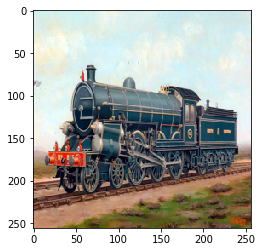

{'aeroplane': 0.010710217, 'bird': 0.021307072, 'boat': 0.104646064, 'chair': 0.024634711, 'cow': 0.006254345, 'diningtable': 0.010050898, 'dog': 0.0665563, 'horse': 0.07958088, 'sheep': 0.0069674, 'train': 0.96350926}


In [68]:
labels_lst = ['aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'sheep', 'train']

# show the inputs and predicted outputs
for i in range(len(X_test)):
    if i < 10:
        plt.imshow(X_test[i], interpolation="nearest")
        plt.show()
        pred_dict = dict(zip(labels_lst, y_pred[i]))
        print(pred_dict)

In [81]:
proba = y_pred

In [83]:
proba[1]

array([0.00699088, 0.0738465 , 0.7109203 , 0.05285222, 0.06628267,
       0.02738944, 0.06869952, 0.06838873, 0.05585682, 0.02190949],
      dtype=float32)

In [95]:
proba[0]

array([0.01151065, 0.05898029, 0.4657647 , 0.10778029, 0.05964142,
       0.13066083, 0.07446681, 0.0835417 , 0.02796149, 0.0679767 ],
      dtype=float32)

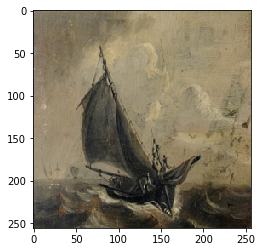

{'aeroplane': 0.011510649, 'bird': 0.058980286, 'boat': 0.4657647, 'chair': 0.107780285, 'cow': 0.05964142, 'diningtable': 0.13066083, 'dog': 0.07446681, 'horse': 0.0835417, 'sheep': 0.027961489, 'train': 0.0679767}
the top 3 classes are: boat, diningtable and chair


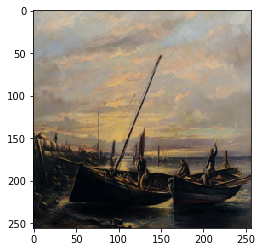

{'aeroplane': 0.0069908835, 'bird': 0.073846504, 'boat': 0.7109203, 'chair': 0.052852217, 'cow': 0.06628267, 'diningtable': 0.027389439, 'dog': 0.068699524, 'horse': 0.06838873, 'sheep': 0.055856816, 'train': 0.021909487}
the top 3 classes are: boat, bird and dog


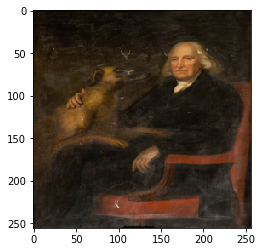

{'aeroplane': 0.0029774709, 'bird': 0.13786562, 'boat': 0.0416988, 'chair': 0.732465, 'cow': 0.020253956, 'diningtable': 0.43880045, 'dog': 0.15119307, 'horse': 0.086714655, 'sheep': 0.028905299, 'train': 0.010970064}
the top 3 classes are: chair, diningtable and dog


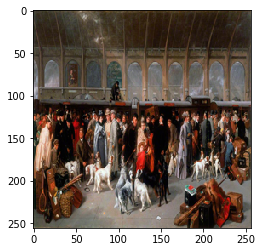

{'aeroplane': 0.00047224207, 'bird': 0.19782655, 'boat': 0.05197912, 'chair': 0.25675035, 'cow': 0.0047155037, 'diningtable': 0.38016063, 'dog': 0.21556155, 'horse': 0.040112652, 'sheep': 0.0067676483, 'train': 0.18043947}
the top 3 classes are: diningtable, chair and dog


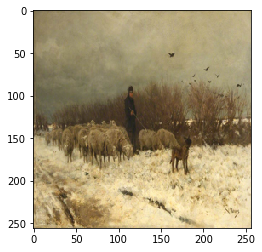

{'aeroplane': 0.013747182, 'bird': 0.08043737, 'boat': 0.33191603, 'chair': 0.029723644, 'cow': 0.09929886, 'diningtable': 0.057096746, 'dog': 0.16526976, 'horse': 0.1510413, 'sheep': 0.06962299, 'train': 0.01585079}
the top 3 classes are: boat, dog and horse


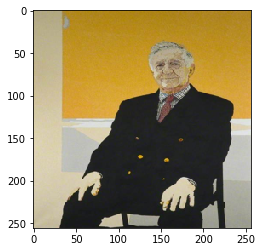

{'aeroplane': 0.00696808, 'bird': 0.030701378, 'boat': 0.25352976, 'chair': 0.22637038, 'cow': 0.002274111, 'diningtable': 0.2212968, 'dog': 0.066337705, 'horse': 0.029711854, 'sheep': 0.007477059, 'train': 0.016330788}
the top 3 classes are: boat, chair and diningtable


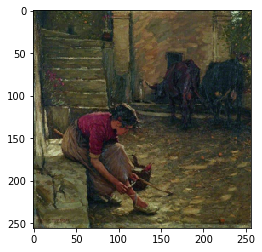

{'aeroplane': 0.014491059, 'bird': 0.25544348, 'boat': 0.11032209, 'chair': 0.24605648, 'cow': 0.075736314, 'diningtable': 0.29747686, 'dog': 0.23127078, 'horse': 0.1251727, 'sheep': 0.07669094, 'train': 0.120897636}
the top 3 classes are: diningtable, bird and chair


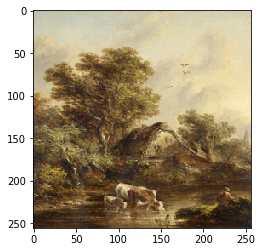

{'aeroplane': 0.0015015261, 'bird': 0.017672215, 'boat': 0.22402391, 'chair': 0.031162668, 'cow': 0.13949892, 'diningtable': 0.021721153, 'dog': 0.12647809, 'horse': 0.30596307, 'sheep': 0.11625271, 'train': 0.016982079}
the top 3 classes are: horse, boat and cow


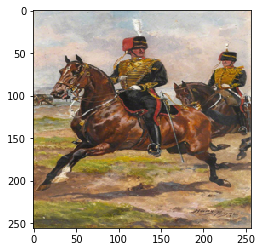

{'aeroplane': 0.002885907, 'bird': 0.06951065, 'boat': 0.05603365, 'chair': 0.046981283, 'cow': 0.033574387, 'diningtable': 0.05298028, 'dog': 0.1545101, 'horse': 0.28438777, 'sheep': 0.060476657, 'train': 0.036165845}
the top 3 classes are: horse, dog and bird


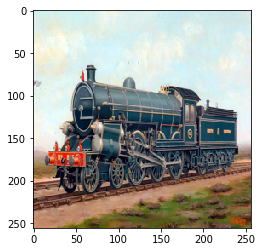

{'aeroplane': 0.010710217, 'bird': 0.021307072, 'boat': 0.104646064, 'chair': 0.024634711, 'cow': 0.006254345, 'diningtable': 0.010050898, 'dog': 0.0665563, 'horse': 0.07958088, 'sheep': 0.0069674, 'train': 0.96350926}
the top 3 classes are: train, boat and horse


In [99]:
for i in range(len(X_test)):
    if i < 10:
        top_3 = np.argsort(proba[i])[:-4:-1]
        plt.imshow(X_test[i], interpolation="nearest")
        plt.show()
        pred_dict = dict(zip(labels_lst, y_pred[i]))
        print(pred_dict)
        print(f"the top 3 classes are: {labels_lst[top_3[0]]}, {labels_lst[top_3[1]]} and {labels_lst[top_3[2]]}")

In [80]:
report = classification_report(y_test, y_pred, output_dict=False, target_names=labels_lst)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [62]:
y_pred = model.predict(X_test)

55/55 [==============================] - 7s 119ms/step


In [75]:
predict_classes=np.argmax(y_pred,axis=1)
predict_classes[0]

2

In [51]:
yhat = y_pred
yhat = yhat.round()
# calculate accuracy
acc = accuracy_score(y_test, yhat)
# store result
print('>%.3f' % acc)

>0.135


In [59]:
[0]
proba
idxs = np.argsort(proba)[::-1][:2]
top_3

array([2, 5, 3])

In [ ]:
for i in range(3):
    print("{}".format(labels_lst[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))

plt.imshow(img)

# for (i, j) in enumerate(idxs):
#     # build the label and draw the label on the image

#     label = "{}: {:.2f}%".format(mlb.classes_[j], proba[j] * 100)

# 	cv2.putText(output, label, (10, (i * 30) + 25), 
# 		cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
# # show the probabilities for each of the individual labels
# for (label, p) in zip(mlb.classes_, proba):
# 	print("{}: {:.2f}%".format(label, p * 100))
# # show the output image
# cv2.imshow("Output", output)
# cv2.waitKey(0)

In [ ]:
for i in range(len(X_test)):
    if i < 300:
        plt.imshow(X_test[i], interpolation="nearest")
        plt.show()
        pred_dict = dict(zip(labels_lst, y_pred[i]))
        print(pred_dict)

In [8]:
columns = ["aeroplane", "bird", "boat", "chair", "cow", "diningtable", "dog", "horse", "sheep", "train"]
print(type(columns))

<class 'list'>


In [9]:
img_iter = ImageDataGenerator(rescale=1./255,
                              rotation_range=0.2,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              vertical_flip=True).flow_from_dataframe(df,
                                                                      directory=PATH_YOURPAINTINGS,
                                                                      x_col="filename",
                                                                      y_col=columns,
                                                                      class_mode="multi_output")

Found 8296 validated image filenames.


In [155]:
PATH_IMG = Path(PATH_YOURPAINTINGS/"WYR_KLMUS_1983_744-001.jpg")

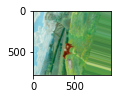

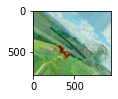

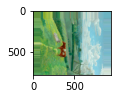

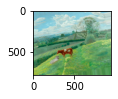

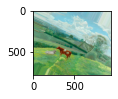

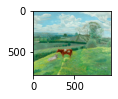

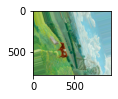

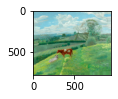

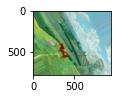

In [160]:
# Importing the required libraries
from numpy import expand_dims

# Loading desired images
img = load_img(PATH_IMG)

# For processing, we are converting the image(s) to an array
data = img_to_array(img)

# Expanding dimension to one sample
samples = expand_dims(data, 0)

# Calling ImageDataGenerator for creating data augmentation generator.
datagen = ImageDataGenerator(rotation_range=90)

it = datagen.flow(samples, batch_size=1)

# Preparing the Samples and Plot for displaying output
for i in range(9):
    # preparing the subplot
    plt.subplot(330 + 1 + i)
    # generating images in batches
    batch = it.next()
    # Remember to convert these images to unsigned integers for viewing 
    image = batch[0].astype('uint8')
    # Plotting the data
    plt.imshow(image)
    # Displaying the figure
    plt.show()

TypeError: Invalid shape (32, 256, 256, 3) for image data

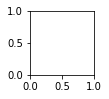

In [148]:
# for i in range(9):
#     plt.subplot(330 + 1 + i)
#     # generate batch of images
#     batch = img_iter.next()
#     # convert to unsigned integers for viewing
#     image = batch[0].astype('uint8')
#     # plot raw pixel data
#     plt.imshow(image)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
model.fit(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)

In [24]:
df.columns

Index(['index', 'Image URL', 'Web page URL', 'Subset', 'Labels', 'filename',
       'labels', 'aeroplane', 'bird', 'boat', 'chair', 'cow', 'diningtable',
       'dog', 'horse', 'sheep', 'train'],
      dtype='object')

In [25]:
df_labels = df.drop(columns=['index', 'Image URL', 'Web page URL', 'Subset', 'Labels', 'labels'])

In [27]:
df_labels_sorted = df_labels.sort_values('filename').tolist()

,filename,aeroplane,bird,boat,chair,cow,diningtable,dog,horse,sheep,train
4384,ABD_AAG_000196-001.jpg,0,0,0,1,0,1,0,0,0,0
6850,ABD_AAG_000720-001.jpg,0,0,0,0,0,1,0,0,0,0
827,ABD_AAG_002200-001.jpg,0,0,1,0,0,0,0,0,0,0
5447,ABD_AAG_002215-001.jpg,0,0,1,0,0,0,0,0,0,0
5867,ABD_AAG_002276-001.jpg,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4114,WYR_WAGY_FA154-001.jpg,0,0,0,0,0,0,0,0,1,0
4115,WYR_WAGY_FA155-001.jpg,0,0,0,0,0,0,0,0,1,0
2769,alfred-wallis-four-boats-by-a-lighthouse.jpg,0,0,1,0,0,0,0,0,0,0
2046,rol02_x01_diogenes_and_belle_at_prayer_with_ch...,0,0,0,1,0,0,0,0,0,0


In [22]:
ds = image_dataset_from_directory(
    directory=PATH_YOURPAINTINGS,
    labels=None,
    batch_size=32,
    image_size=(256, 256))

Found 8255 files belonging to 1 classes.


In [77]:
mlb.classes_

array(['aeroplane', 'bird', 'chair', 'diningtable', 'dog'], dtype=object)

In [76]:
train_datagen = ImageDataGenerator(

test_datagen = ImageDataGenerator(rescale=1./255)

TypeError: __init__() got an unexpected keyword argument 'directory'

In [16]:
ds = image_dataset_from_directory(
    directory=PATH_YOURPAINTINGS,
    labels=None,
    batch_size=32,
    label_mode='categorical',
    image_size=(256, 256))

Found 8255 files belonging to 1 classes.


In [12]:
df

,index,Image URL,Web page URL,Subset,Labels,filename,labels,aeroplane,bird,boat,chair,cow,diningtable,dog,horse,sheep,train
0,0,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/and-the-co...,'test',' cow',NID_QUB_QUB_264-001.jpg,['cow'],0,0,0,0,1,0,0,0,0,0
1,1,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/0-6-00-6-0...,'train',' train',GMIII_MOSI_A1978_72_3-001.jpg,['train'],0,0,0,0,0,0,0,0,0,1
2,2,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/044t-locom...,'train',' train',NY_NRM_1979_7964-001.jpg,['train'],0,0,0,0,0,0,0,0,0,1
3,3,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/080-locomo...,'test',' train',CHE_CRHC_PCF40-001.jpg,['train'],0,0,0,0,0,0,0,0,0,1
4,4,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/17th-and-2...,'test',' horse',NOT_NTMAG_1997_31-001.jpg,['horse'],0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8291,8623,https://d3d00swyhr67nd.cloudfront.net/w944h944...,https://artuk.org/discover/artworks/youth-82434,'test',' diningtable',LLR_AWC_0047-001.jpg,['diningtable'],0,0,0,0,0,1,0,0,0,0
8292,8625,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/yport-20094,'test',' boat',STF_STKMG_1965_FA_10-001.jpg,['boat'],0,0,1,0,0,0,0,0,0,0
8293,8626,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/yport-norm...,'train',' bird',NY_YAG_YORAG_1030-001.jpg,['bird'],0,1,0,0,0,0,0,0,0,0
8294,8627,https://d3d00swyhr67nd.cloudfront.net/w944h944...,https://artuk.org/discover/artworks/zebra-and-...,'train',' bird',GL_GM_A_1989_23_e-001.jpg,['bird'],0,1,0,0,0,0,0,0,0,0


In [ ]:
flow_from_dataframe(
    dataframe,
    directory=None,
    x_col='filename',
    y_col='class',
    weight_col=None,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    subset=None,
    interpolation='nearest',
    validate_filenames=True,
    **kwargs
)

In [21]:
train_generator=flow_from_dataframe(df_yourpaintings,
                                    directory='PATH_YOURPAINTINGS',
                                    x_col='filename',
                                    y_col=columns,
                                    batch_size=32,
                                    class_mode='raw',
                                    shuffle=True,
                                    target_size=(224, 224))

NameError: name 'flow_from_dataframe' is not defined

In [ ]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

In [ ]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

In [61]:
AUTOTUNE = tf.data.AUTOTUNE
ds = ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def get_data():
    """method to get the training data (or a portion of it) from google cloud bucket"""
    df = pd.read_csv(f"gs://{BUCKET_NAME}/{BUCKET_TRAIN_DATA_PATH}", nrows=1000)
    return df

In [ ]:
def download(path, urls):
    # ignore SSL errors
    ssl._create_default_https_context = ssl._create_unverified_context
    for url in tqdm(urls):
        try:
            fname = url[url.rfind('/')+1:]
            downloaded_urls_lst.append(url)
            urllib.request.urlretrieve(url, path/fname)
        except Exception as e:
            logging.error(traceback.format_exc())
            
download(yourpaintings_path, urls)